In [4]:
import matplotlib.pylab as plt

!pip install -q tf-nightly
import tensorflow as tf

     |████████████████████████████████| 517.2MB 29kB/s 
     |████████████████████████████████| 460kB 11.7MB/s 
     |████████████████████████████████| 2.9MB 52.1MB/s 


In [5]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 3.3MB 2.8MB/s 


In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
                                  hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

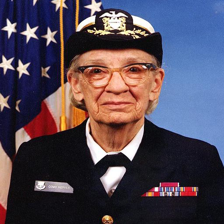

In [22]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [23]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [24]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [25]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

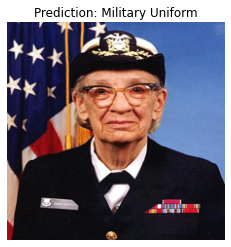

In [28]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [29]:
data_root = tf.keras.utils.get_file(
    'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar = True
)

228818944/228813984 [==============================] - 2s 0us/step


In [30]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size = IMAGE_SHAPE)


Found 3670 images belonging to 5 classes.


In [31]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break
  

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [0]:
result_batch = classifier.predict(image_batch)

In [33]:
result_batch.shape

(32, 1001)

In [34]:
predicted_class_name = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_name

array(['Bedlington terrier', 'daisy', 'bee', 'daisy', 'ant', 'daisy',
       'daisy', 'velvet', 'artichoke', 'ladybug', 'bee', 'bee', 'daisy',
       'chickadee', 'daisy', 'cabbage butterfly', 'daisy', 'velvet',
       'park bench', "yellow lady's slipper", 'daisy', 'bee', 'daisy',
       'daisy', 'daisy', 'daisy', 'toyshop', 'daisy', 'daisy', 'pot',
       'daisy', 'ladybug'], dtype='<U30')

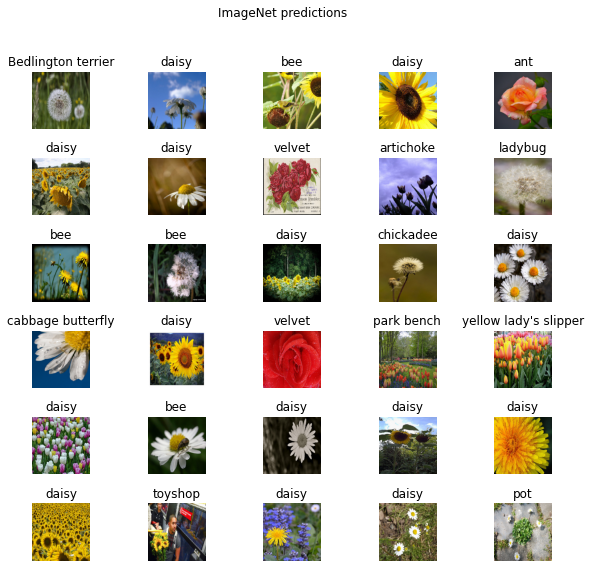

In [37]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_name[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, 
                                         input_shape=(224, 224, 3))

In [41]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [43]:
model = tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(image_data.num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [45]:
predictions.shape


TensorShape([32, 5])

In [0]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])